In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
import tensorflow_io as tfio
print(tfio.__version__)

from tensorflow.keras import layers
from tensorflow.keras import models

import wandb
from wandb.keras import WandbMetricsLogger

2023-03-10 17:52:17.754876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 17:52:18.968430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-10 17:52:18.968589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

2.11.0
0.31.0


In [3]:
data_path = "../data/tfrecords"


def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = sorted(glob(f"{data_path}/*.tfrec"), key=natural_keys)

In [4]:
train_tfrecords, valid_tfrecords = tfrecords[:19], tfrecords[19:]
print(len(train_tfrecords)+len(valid_tfrecords))

24


In [5]:
def parse_sequence(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.float32,
    )


def parse_tfrecord_fn(example):
    feature_description = {
        "n_frames": tf.io.FixedLenFeature([], tf.float32),
        "frames": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    
    return tf.io.parse_single_example(example, feature_description)


NUM_FRAMES = 16

def true_fn(frames, n_frames):
    num_left_frames = NUM_FRAMES - n_frames
    left_frames = tf.zeros(shape=(num_left_frames, 543, 3))
    frames = tf.concat([frames, left_frames], 0)

    return frames


def false_fn(frames):
    frames = tf.slice(
        frames,
        begin=[0,0,0],
        size=[NUM_FRAMES, 543, 3]
    )
    
    return frames


@tf.function
def preprocess_frames(frames, n_frames):
    """This is where different preprocessing logics will be experimented."""
    # nan to num
    frames = tf.where(tf.math.is_nan(frames), 0.0, frames)
    
    # sample frames
    frames = tf.cond(
        tf.less(n_frames, NUM_FRAMES),
        true_fn = lambda: true_fn(frames, n_frames),
        false_fn = lambda: false_fn(frames),
    )
    
    return frames


def parse_data(example):
    # Parse Frames
    n_frames = example["n_frames"]
    frames = tf.reshape(parse_sequence(example["frames"]), shape=(n_frames, 543, 3))
    frames = preprocess_frames(frames, n_frames)
    
    # Parse Labels
    label = tf.one_hot(example["label"], depth=250)

    return frames, label

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.TFRecordDataset(train_tfrecords)
valid_ds = tf.data.TFRecordDataset(valid_tfrecords)

trainloader = (
    train_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(1024)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)

validloader = (
    valid_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)

In [8]:
samples, labels = next(iter(trainloader))
samples.shape

TensorShape([128, 16, 543, 3])

In [11]:
LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

In [12]:
face_inputs = samples[:, :, 0:468, :]
left_hand_inputs = samples[:, :, 468:489, :]
pose_inputs = samples[:, :, 489:522, :]
right_hand_inputs = samples[:, :,522:,:]

In [28]:
face_vector = conv1d_lstm_block(face_inputs, [32, 64])
left_hand_vector = conv1d_lstm_block(left_hand_inputs, [64])
right_hand_vector = conv1d_lstm_block(right_hand_inputs, [64])
pose_vector = conv1d_lstm_block(pose_inputs, [64])

2023-03-10 14:49:37.612889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


In [31]:
vector = tf.keras.layers.Concatenate(axis=1)([face_vector, left_hand_vector, right_hand_vector, pose_vector])

In [33]:
vector.shape

TensorShape([128, 125, 64])

In [ ]:
tf.keras.layers.LSTM(4)(vector)

In [15]:
def conv1d_lstm_block(inputs, filters):
    vector = tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=8)(inputs)
    for f in filters:
        vector = tf.keras.layers.Conv1D(filters=f, kernel_size=8)(vector)
        vector = tf.keras.layers.MaxPooling1D()(vector)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    return vector


def get_model():
    inputs = tf.keras.Input((NUM_FRAMES, 543, 3), dtype=tf.float32)

    # Features
#     face_inputs = inputs[:, :, 0:468, :]
    lip_inputs = tf.gather(inputs, indices=LIP, axis=2)
    left_hand_inputs = inputs[:, :, 468:489, :]
    pose_inputs = inputs[:, :, 489:522, :]
    right_hand_inputs = inputs[:, :,522:,:]

    lip_vector = conv1d_lstm_block(lip_inputs, [32, 64])
    left_hand_vector = conv1d_lstm_block(left_hand_inputs, [64])
    right_hand_vector = conv1d_lstm_block(right_hand_inputs, [64])
#     pose_vector = conv1d_lstm_block(pose_inputs, [64])
    
    vector = tf.keras.layers.Concatenate(axis=1)([lip_vector, left_hand_vector, right_hand_vector])
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 16, 40, 3)   0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 33, 32)       35968       ['tf.compat.v1.gather[0][0]']    
                                                                                              

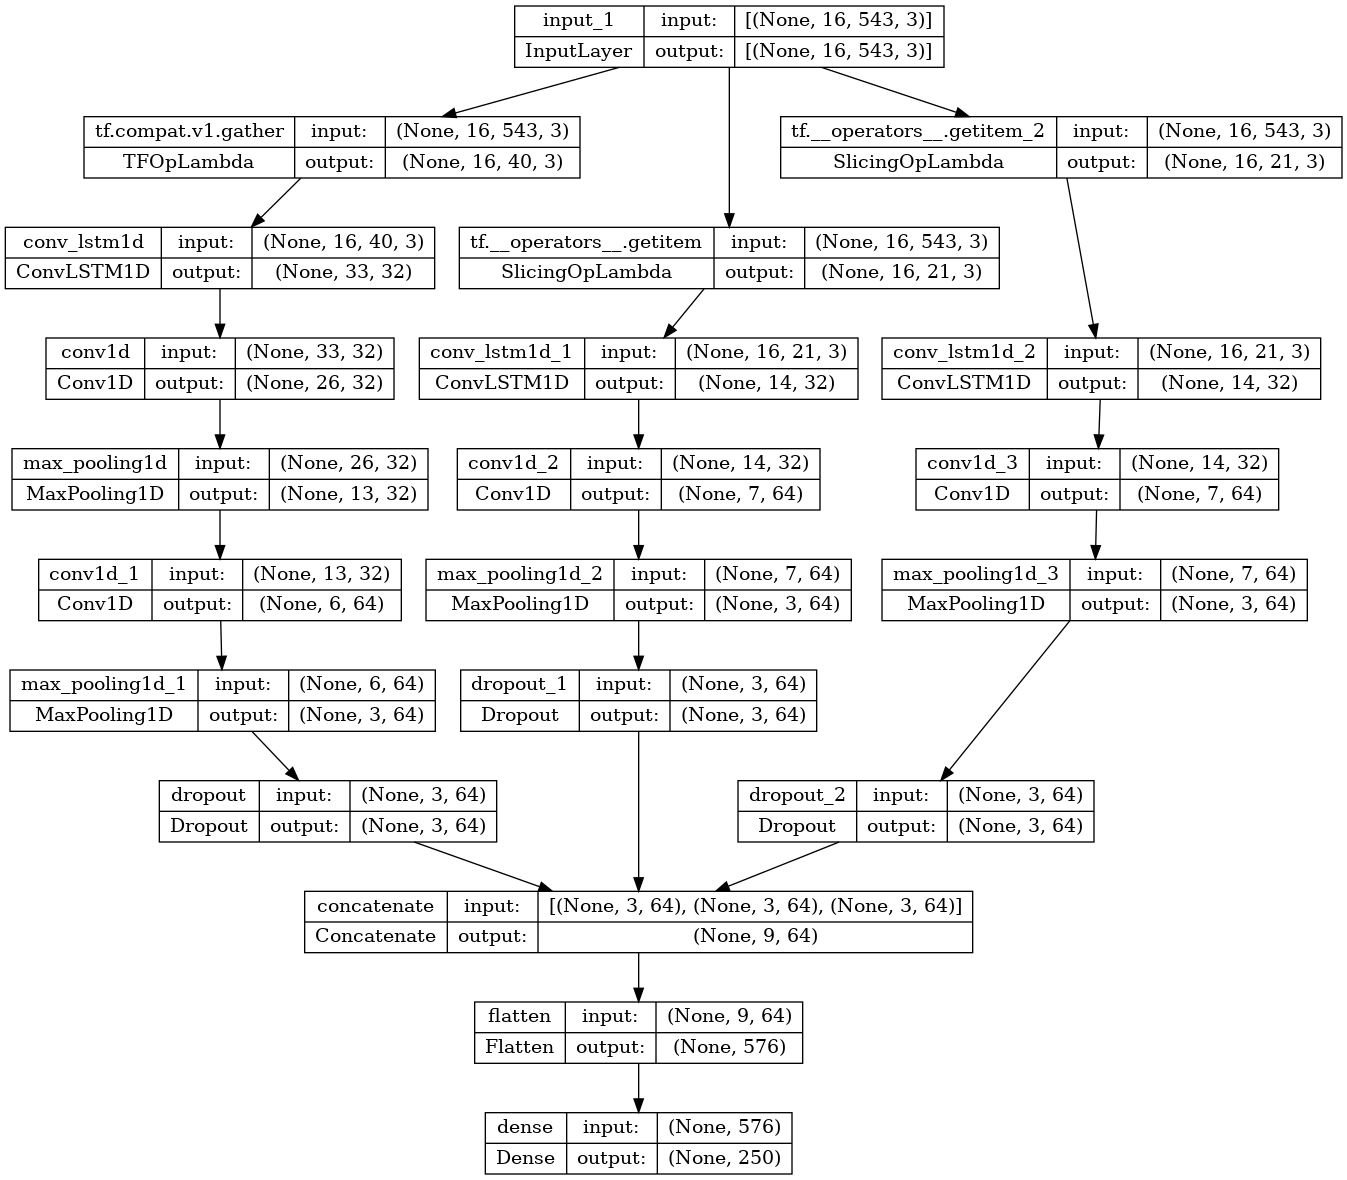

In [16]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [17]:
model(samples)

2023-03-10 17:59:22.427168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


<tf.Tensor: shape=(128, 250), dtype=float32, numpy=
array([[0.00413458, 0.00401624, 0.00402299, ..., 0.00312232, 0.00395929,
        0.0040281 ],
       [0.00431549, 0.00413428, 0.00409446, ..., 0.00353511, 0.0040746 ,
        0.00373209],
       [0.00417831, 0.00397379, 0.0040494 , ..., 0.00313451, 0.00393998,
        0.00405095],
       ...,
       [0.0042284 , 0.00379784, 0.00413297, ..., 0.00360335, 0.00380803,
        0.00385044],
       [0.00413593, 0.00387397, 0.00421564, ..., 0.00343407, 0.00388658,
        0.00383097],
       [0.00403642, 0.00394009, 0.00419364, ..., 0.00335988, 0.00387304,
        0.00395775]], dtype=float32)>